In [29]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style='whitegrid')
df = pd.read_csv('./data/SNCF_API.csv',parse_dates=['date'])
df = df.drop('Unnamed: 0',axis=1)
df = df.sort_values(by='date',axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 70 to 225
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  226 non-null    datetime64[ns]
 1   gare_arrivee                          226 non-null    object        
 2   duree_moyenne                         226 non-null    int64         
 3   nb_train_prevu                        226 non-null    int64         
 4   nb_annulation                         226 non-null    int64         
 5   nb_train_depart_retard                226 non-null    int64         
 6   retard_moyen_depart                   226 non-null    float64       
 7   nb_train_retard_arrivee               226 non-null    int64         
 8   retard_moyen_arrivee                  226 non-null    float64       
 9   nb_train_retard_sup_15                226 non-null    int64         
 10  nb_tra

## Data Analyzis

In [20]:
print(df['gare_arrivee'].unique())

['GENEVE' 'ZURICH' 'ITALIE' 'LAUSANNE' 'BARCELONA' 'FRANCFORT' 'STUTTGART']


Text(0.5, 0, 'Minutes of Delay')

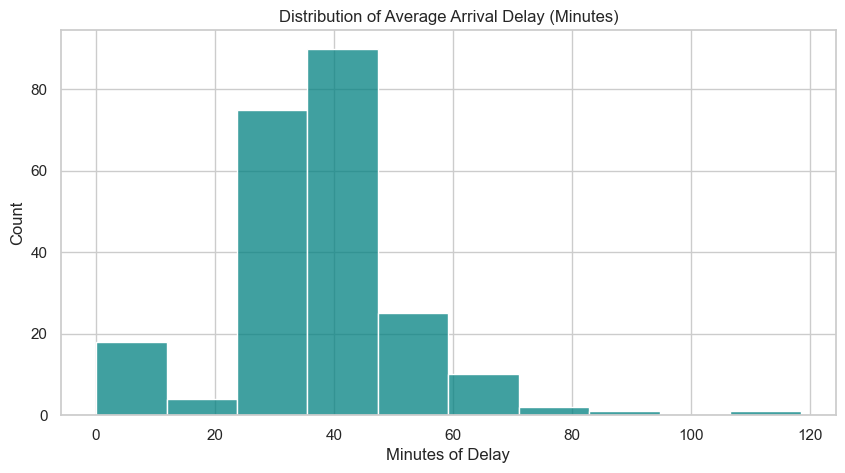

In [27]:
plt.figure(figsize=(10,5))
sns.histplot(df['retard_moyen_arrivee'],bins=10,color='teal')
plt.title('Distribution of Average Arrival Delay (Minutes)')
plt.xlabel('Minutes of Delay')

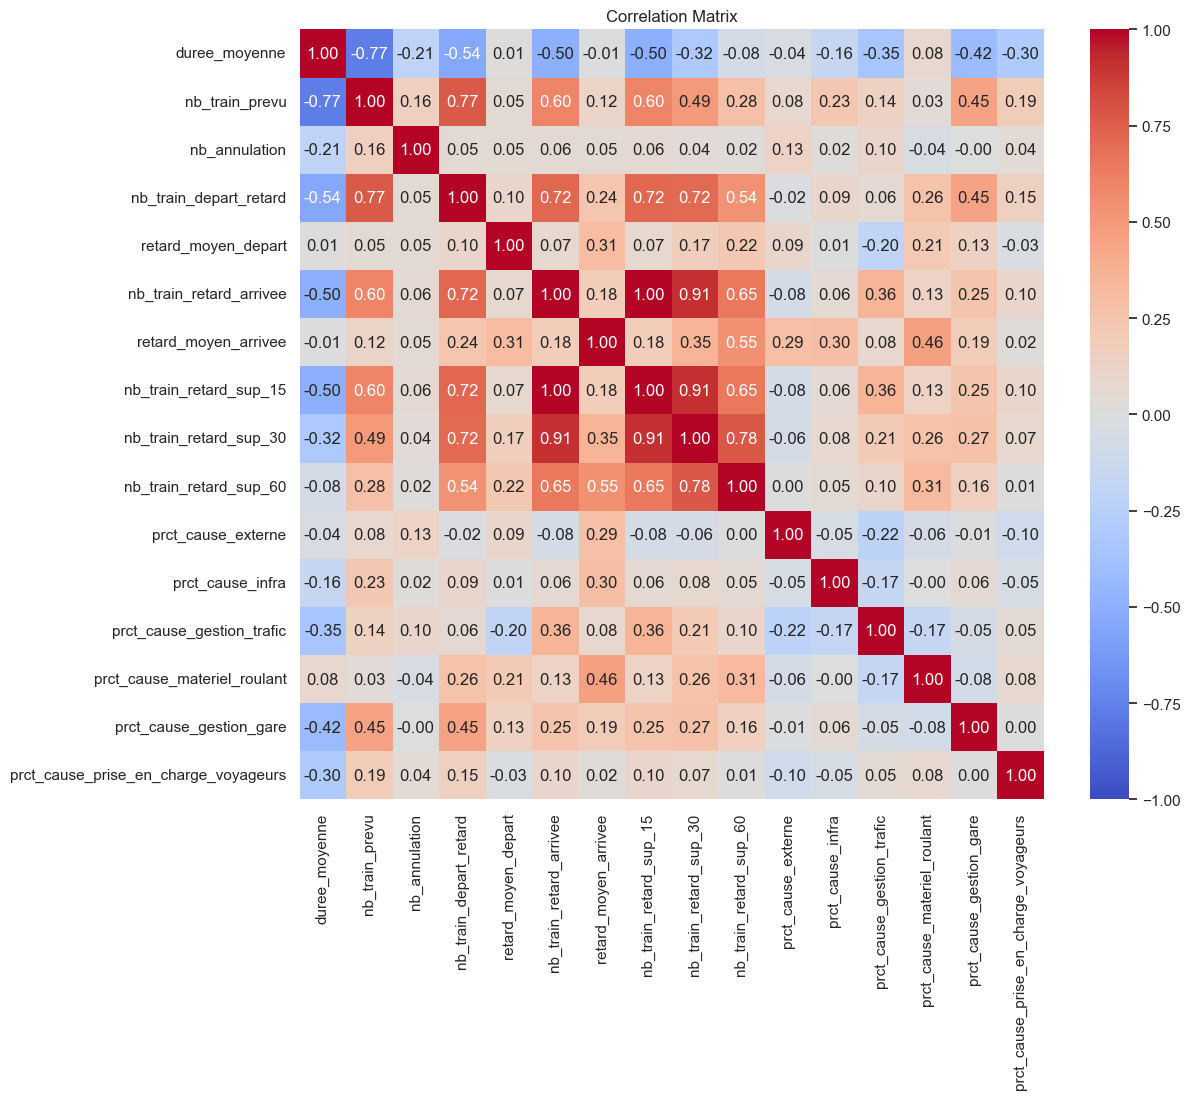

In [32]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Text(0, 0.5, 'Arrival Delay (min)')

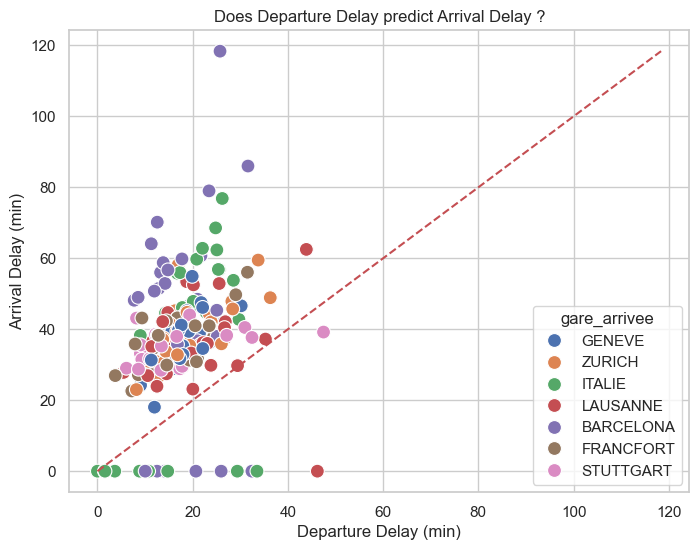

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['retard_moyen_depart'],y=df['retard_moyen_arrivee'],hue=df['gare_arrivee'],s=100)
max_value = max(df['retard_moyen_arrivee'].max(),df['retard_moyen_depart'].max())
min_value = min(df['retard_moyen_arrivee'].min(),df['retard_moyen_depart'].min())
plt.plot([min_value,max_value],[min_value,max_value],'r--')
plt.title("Does Departure Delay predict Arrival Delay ?")
plt.xlabel('Departure Delay (min)')
plt.ylabel('Arrival Delay (min)')

> Thanks to these two graphs, we clearly see that departure delay is strongly correlated to arrival delay. Because we want to predict the arrival delay, we need in addition to remove the column corresponding to the departure delay during our training, to prevent data leakage.

>Beyond timing, the heatmap reveals which specific operational issues drive the biggest delays: prct_cause_materiel_roulant (**0.46**), prct_cause_infra (**0.30**), and prct_cause_externe (**0,29**)

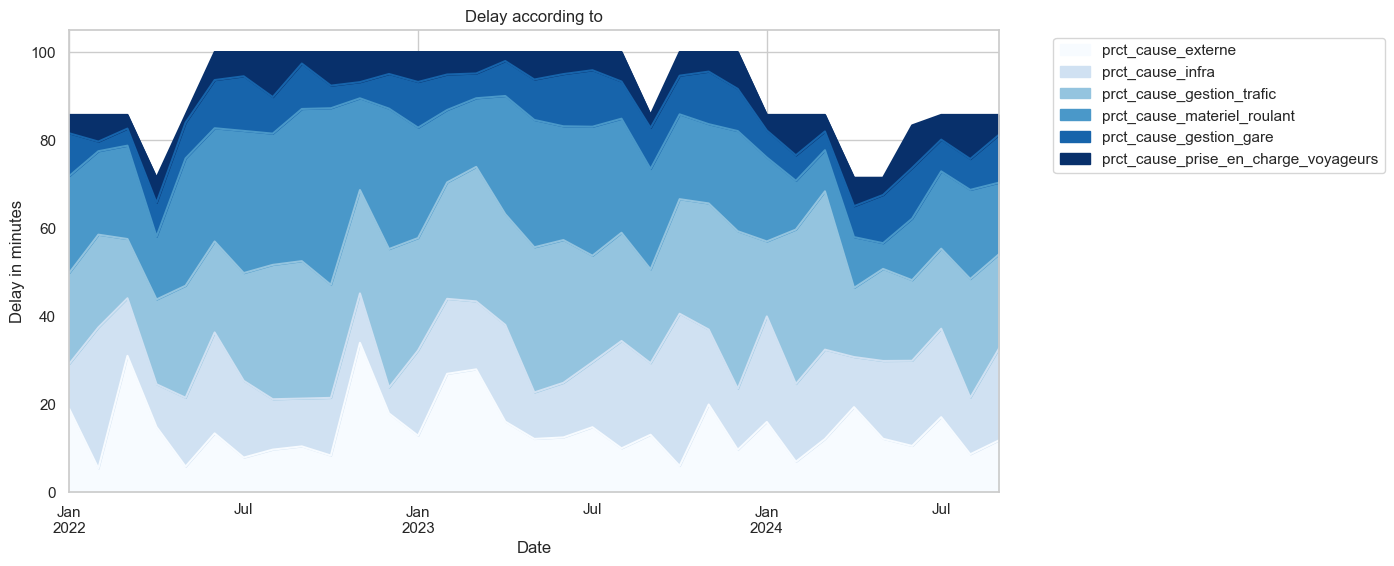

In [100]:
all_prct = [c for c in df.columns if 'prct' in c]
df_by_month = df[['date'] + all_prct].groupby('date').mean()
df_by_month.plot.area(figsize=(12,6),cmap='Blues')
plt.xlabel('Date')
plt.ylabel('Delay in minutes')
plt.title('Delay according to')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

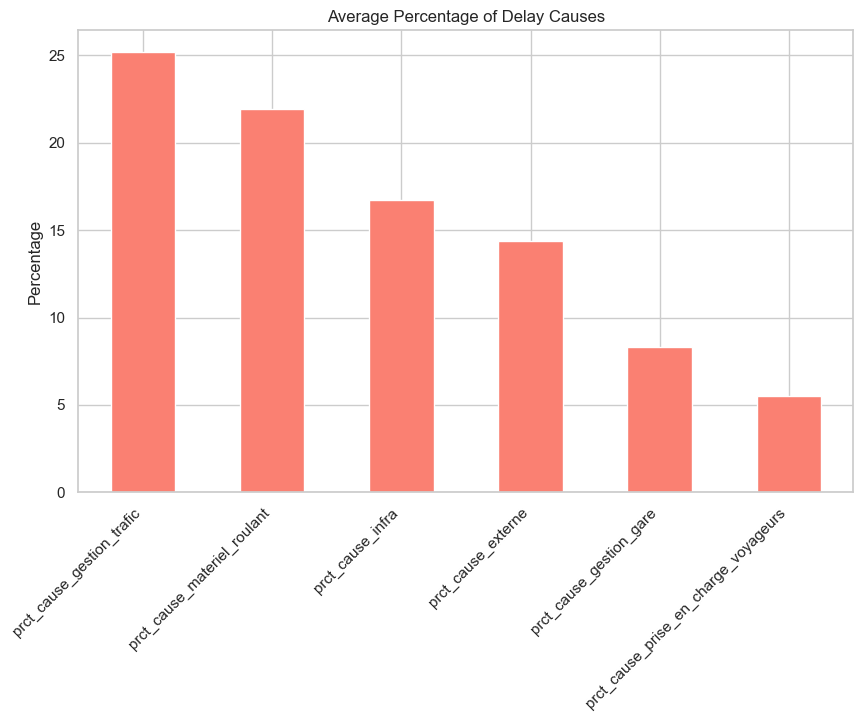

In [105]:
cause_cols = [c for c in df.columns if 'prct_cause' in c]
avg_causes = df[cause_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
avg_causes.plot.bar(color='salmon')
plt.title('Average Percentage of Delay Causes')
plt.ylabel('Percentage')
plt.xticks(rotation=45,ha='right')
plt.show()

> We notice here that most of the delay is due to the trafic management (cause_gestion_trafic). However, in our correlation matrix, this feature is poorly correlated with the finaly delay. This indicates that these incidents are frequent but usually short, having a limited impact on the total delay.

>Based on our correlation analysis, we decide to keep only prct_cause_infra, prct_cause_materiel_roulant, and prct_cause_externe in our features

> Note on Data Leakage & Project Scope: We acknowledge that the 'Cause' columns are determined post-trip, which would technically constitute data leakage if our goal was pure real-time prediction.

## Data Preparation

In [207]:
from sklearn.model_selection import train_test_split

features = [
    'gare_arrivee',
    'date',
    'prct_cause_infra', 
    'prct_cause_materiel_roulant', 
    'prct_cause_externe',
    'retard_moyen_arrivee'
]
data = df[features]
X = data.drop(['retard_moyen_arrivee'],axis=1)
y = data['retard_moyen_arrivee']

X = pd.get_dummies(X,columns=['gare_arrivee'],drop_first=True,dtype=int).reset_index(drop=True)
X['month'] = X['date'].dt.month
X['year'] = X['date'].dt.year
X = X.drop('date',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)

In [231]:
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=4)
estimator = Pipeline([('scaler',StandardScaler()),('model',Ridge())])
param_grid = {
  'model__max_iter' : [50,100,250,500,1000],
  'model__alpha' : [0.01,0.1,0.5,1.0,10,20,5,100]
}

grid_search = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=tscv,scoring='neg_mean_absolute_error')
grid_search.fit(X_train,y_train)

,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': [0.01, 0.1, ...], 'model__max_iter': [50, 100, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [232]:
from sklearn.metrics import r2_score,root_mean_squared_error

model = grid_search.best_estimator_
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
std_dev = y_test.std()
print(f"Standard Deviation of Delays: {std_dev:.2f} minutes")

print(r2,rmse)


Standard Deviation of Delays: 18.32 minutes
0.3342747724772588 14.786619994037009
